In [ ]:
!python3.11 -m pip install transformers huggingface_hub datasets peft trl bitsandbytes evaluate matplotlib rouge-score bert_score
!python3.11 -m pip install --upgrade jupyter
!python3.11 -m pip install --upgrade ipywidgets

In [5]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer, 
    BitsAndBytesConfig,
    AutoTokenizer,
)
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments
from trl import SFTTrainer
import json

In [6]:
dir = "../instructions/"
datasets = ["highD","ngsim","road_networks","tlc_trip","urban_flow_prediction_survey"]
multiple_select = []
short_answer = []
custom_ds = pd.DataFrame()
prompts = []
for d in datasets:
    with open(dir+d+"_instructions_generated.json", 'r') as f:
      data = json.load(f)
      data_multiple_select = data[0]
      for i in data_multiple_select["Positive Example"]:
        prompt = i["Input"] + "\n" + "The answer to the question is:" + "\n" + i["Output"] + "\nThe reason for the answer is: " + i["Explanation"]
        prompts.append(prompt)
      for i in data_multiple_select["Negative Example"]:
        prompt = i["Input"] + "\n" + "The answer to the question is definitely not the following:" + "\n" + i["Output"] + "\nThe reason for it's not the answer is: " + i["Explanation"]
        prompts.append(prompt)

      data_short_answer = data[1]
      for i in data_short_answer["Positive Example"]:
        prompt = i["Input"] + "\n" + "The answer to the question is:" + "\n" + i["Output"] + "\nThe reason for the answer is: " + i["Explanation"]
        prompts.append(prompt)
      for i in data_short_answer["Negative Example"]:
        prompt = i["Input"] + "\n" + "The answer to the question is definitely not the following:" + "\n" + i["Output"] + "\nThe reason for it's not the answer is: " + i["Explanation"]
        prompts.append(prompt)
custom_ds["prompt"] = prompts
dataset = Dataset.from_pandas(custom_ds)
train_test_dataset = dataset.train_test_split(test_size=0.2)
model_name = "google-bert/bert-base-cased"

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

# Load the model without quantization (no BitsAndBytesConfig)
model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Your model name
    trust_remote_code=True
)
model.config.use_cache = False

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Configure LoRA
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply LoRA to the model
model = get_peft_model(model, peft_config)



If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
C:\Users\huawe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
output_dir = "./results"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 200
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 300
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=False
)

In [11]:
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=dataset,
#     peft_config=peft_config,
#     dataset_text_field="prompt",
#     max_seq_length=model.config.max_position_embeddings,
#     tokenizer=tokenizer,
#     args=training_arguments,
# )
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# for name, module in trainer.model.named_modules():
#     if "norm" in name:
#         module = module.to(torch.float32)
# trainer.train()

0

In [20]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

In [6]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

<Axes: xlabel='step'>

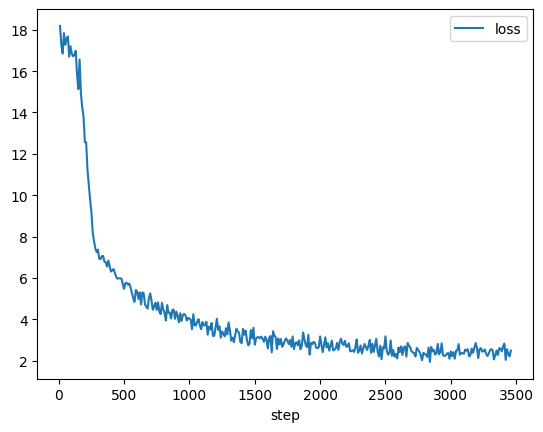

In [27]:
# draw output graph
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

directory = "./results"
json_file_path = os.path.join(directory,"checkpoint-3465","trainer_state.json")
results = json.load(open(json_file_path,"r"))["log_history"]
results_df = pd.DataFrame(results)
# results_df.plot(x="step",y="loss",kind="line")
results_df.plot(
    x="step",
    y="loss",
    kind="line"
)

In [8]:
text = dataset["prompt"][0]
text

'How was this data created? (A)Using a drone. (B)Manually collected (C)Via traffic cameras (D)By police department\nThe answer to the question is:\nA\nThe reason for the answer is: This data was generated using a drone'

In [12]:
import torch
import numpy as np

# Example text input from the dataset
text = dataset["prompt"][0]

# Set device to CPU
device = "cpu"

# Initialize an empty list to store predictions
preds = []

# Tokenize the input text and move the tensors to the CPU
inputs = tokenizer(text, return_tensors="pt").to(device)

# Generate the outputs using the model
outputs = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_length=500,  # Adjusted max_length if needed
    return_dict_in_generate=True,
    output_scores=True,
)

# Get the probabilities for the first token
first_token_probs = outputs.scores[0][0]

# Convert the list of option indices to a torch tensor for indexing
option_indices = torch.tensor([319, 350, 315, 360], dtype=torch.long)

# Calculate the scores for specific options (ABC/319, B/350, etc.)
option_scores = first_token_probs[option_indices].float().cpu().numpy()  # ABCD

# Get the top 3 predictions based on scores
pred = np.array(["A", "B", "C", "D"])[np.argsort(option_scores)[::-1][:3]]

# Join predictions into a single string and append to preds list
pred = " ".join(pred)
preds.append(pred)

# Optionally print the decoded output (without special tokens)
print(tokenizer.decode(outputs.sequences[0], skip_special_tokens=True))


How was this data created? ( A ) Using a drone. ( B ) Manually collected ( C ) Via traffic cameras ( D ) By police department The answer to the question is : A The reason for the answer is : This data was generated using a drone.............................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [12]:
import torch
import evaluate

# Load the ROUGE metric from the evaluate library
rouge = evaluate.load("rouge")

# Example list of texts (prompts) and reference summaries from the dataset
prompts = dataset["prompt"][:10] 
references = dataset["prompt"][:10]

# Set device to CPU (or use GPU if available)
device = "cpu"

# Tokenize the input texts in batches (adjust batch size as needed)
batch_size = 4  # Example batch size
predictions = []

for i in range(0, len(prompts), batch_size):
    # Take a batch of prompts
    batch_prompts = prompts[i:i + batch_size]
    
    # Tokenize the batch of texts
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Generate the outputs for the batch using the model
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=500,  # Adjust max_length based on your task
        return_dict_in_generate=True,
        output_scores=True,
    )
    
    # Decode the generated outputs into text and append to predictions list
    batch_predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs.sequences]
    predictions.extend(batch_predictions)

# Calculate ROUGE score using evaluate package
rouge_results = rouge.compute(predictions=predictions, references=references)

# Print the ROUGE results
rouge_results

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


{'rouge1': 0.4075022659601612,
 'rouge2': 0.4050088835628053,
 'rougeL': 0.40838248273421635,
 'rougeLsum': 0.4085602397395034}

In [15]:
bertscore = evaluate.load("bertscore")
bert_results = bertscore.compute(predictions=predictions, references=references, lang="en")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\huawe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\huawe\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

C:\Users\huawe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
sum(bert_results["f1"])/len(bert_results["f1"])

0.8367290437221527

llama3 t5 decoder model
f1 score
log each iteration
draw graph
f1 bleu score